In [8]:
from absl import logging
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Add,Concatenate,Conv2D,Input,Lambda,LeakyReLU,MaxPool2D,UpSampling2D,ZeroPadding2D,BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import binary_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,TensorBoard
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from seaborn import color_palette
import cv2
import pandas as pd
from tqdm import tqdm
import os
import tensorflow as tf
import time
from tqdm import tqdm
import datetime
import csv
from matplotlib import patches
# from my_yolo import *

In [9]:
images = os.listdir(r"C:\Users\BMEI CMU\Documents\GitHub\WORK\Windows\CODE_BME\PROJECT_MALARIA\malaria\images") # read the images data where all images are present
train = pd.read_json(r"C:\Users\BMEI CMU\Documents\GitHub\WORK\Windows\CODE_BME\PROJECT_MALARIA\malaria\training.json") # read the train json file where info about all images
# are given including bounding box information.
test = pd.read_json(r"C:\Users\BMEI CMU\Documents\GitHub\WORK\Windows\CODE_BME\PROJECT_MALARIA\malaria\test.json") # read the test json file.

In [10]:
# here we have store train and test image in different list
train_image = [] # train images stored here
test_image = [] # test images stored here
for df in train['image']:
    train_image.append(df['pathname'].split('/')[-1])
for df in test['image']:
    test_image.append(df['pathname'].split('/')[-1])
print("Train image length is -> ",len(train_image))
print("Train image :",train_image[:5])
print("Test image length is -> ",len(test_image))
print("Test image :",test_image[:5])

class_dict = {'red blood cell':0,'trophozoite': 1, 'schizont': 2, 'difficult': 3, 'ring': 4,
              'leukocyte': 5, 'gametocyte': 6}

#class_dict = {'uninfected': 0, 'infected': 1}
# we have defined the dictionary for labels or classes.

Train image length is ->  1208
Train image : ['8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png', '10be6380-cbbb-4886-8b9e-ff56b1710576.png', '6b14c855-8561-417c-97a4-63fa552842fd.png', '13099edb-35d9-438f-b093-2cf2ebf9d255.png', '2559636b-f01a-4414-93da-210c3b12d153.png']
Test image length is ->  120
Test image : ['41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg', '64985a1e-16bb-4016-a01c-c21a5b86e572.jpg', 'c70894fa-50e8-4eed-a5a8-159a20153a49.jpg', 'abb72ce2-4193-4dd3-a34c-61c2ee22ccff.jpg', '8db76867-671a-4488-a7b6-991e4dd2e05f.jpg']


In [11]:
img_info = [] # containg information of bounding box
for row in range(train.shape[0]):
    path = os.path.normpath(
        os.path.join(
            r"C:\Users\BMEI CMU\Documents\GitHub\WORK\Windows\CODE_BME\PROJECT_MALARIA\malaria",
            train.iloc[row]['image']['pathname'].lstrip("/")
        )
    )
    for info in train.iloc[row]['objects']:
        category = info['category'] #  category here refer to label 
        bounding_box = info['bounding_box'] # containing image info like r_min,r_max,c_min,c_max
        box_dim = bounding_box['maximum']['r'],bounding_box['maximum']['c'],bounding_box['minimum']['r'],bounding_box['minimum']['c'],category,path
        img_info.append(box_dim)
for row in range(test.shape[0]):
    path = os.path.normpath(
        os.path.join(
            r"C:\Users\BMEI CMU\Documents\GitHub\WORK\Windows\CODE_BME\PROJECT_MALARIA\malaria",
            test.iloc[row]['image']['pathname'].lstrip("/")
        )
    )
    for info in test.iloc[row]['objects']:
        category = info['category'] #  category here refer to label 
        bounding_box = info['bounding_box'] # containing image info like r_min,r_max,c_min,c_max
        box_dim = bounding_box['maximum']['r'],bounding_box['maximum']['c'],bounding_box['minimum']['r'],bounding_box['minimum']['c'],category,path
        img_info.append(box_dim)
# storing each images info in train_img_info list

headers = [ 'max_r', 'max_c', 'min_r','min_c', 'category','img_path']
with open('all_data.csv', 'w') as f:
        wr = csv.writer(f, quoting=csv.QUOTE_ALL)
        wr.writerow(headers) 
        wr.writerows(img_info)
# the above code snippet is taking each data and writing it into train csv file.


# after seperating out each cell data in images we have got 80113 cells info.
# here max_r,min_r,max_c,min_c are dimension for each cell which will help us out while cropping that cell in an image.
# so each image contain various malaria cells including all 6 types of cells.
# As we will see in further analysis that RBC has outnumbered other cell categories 

df = pd.read_csv("all_data.csv")

print("This malaria image data contains rows {} and columns {}".format(df.shape[0],df.shape[1]))
df['label'] = df['category'].map(class_dict) 

data = df

This malaria image data contains rows 86035 and columns 6


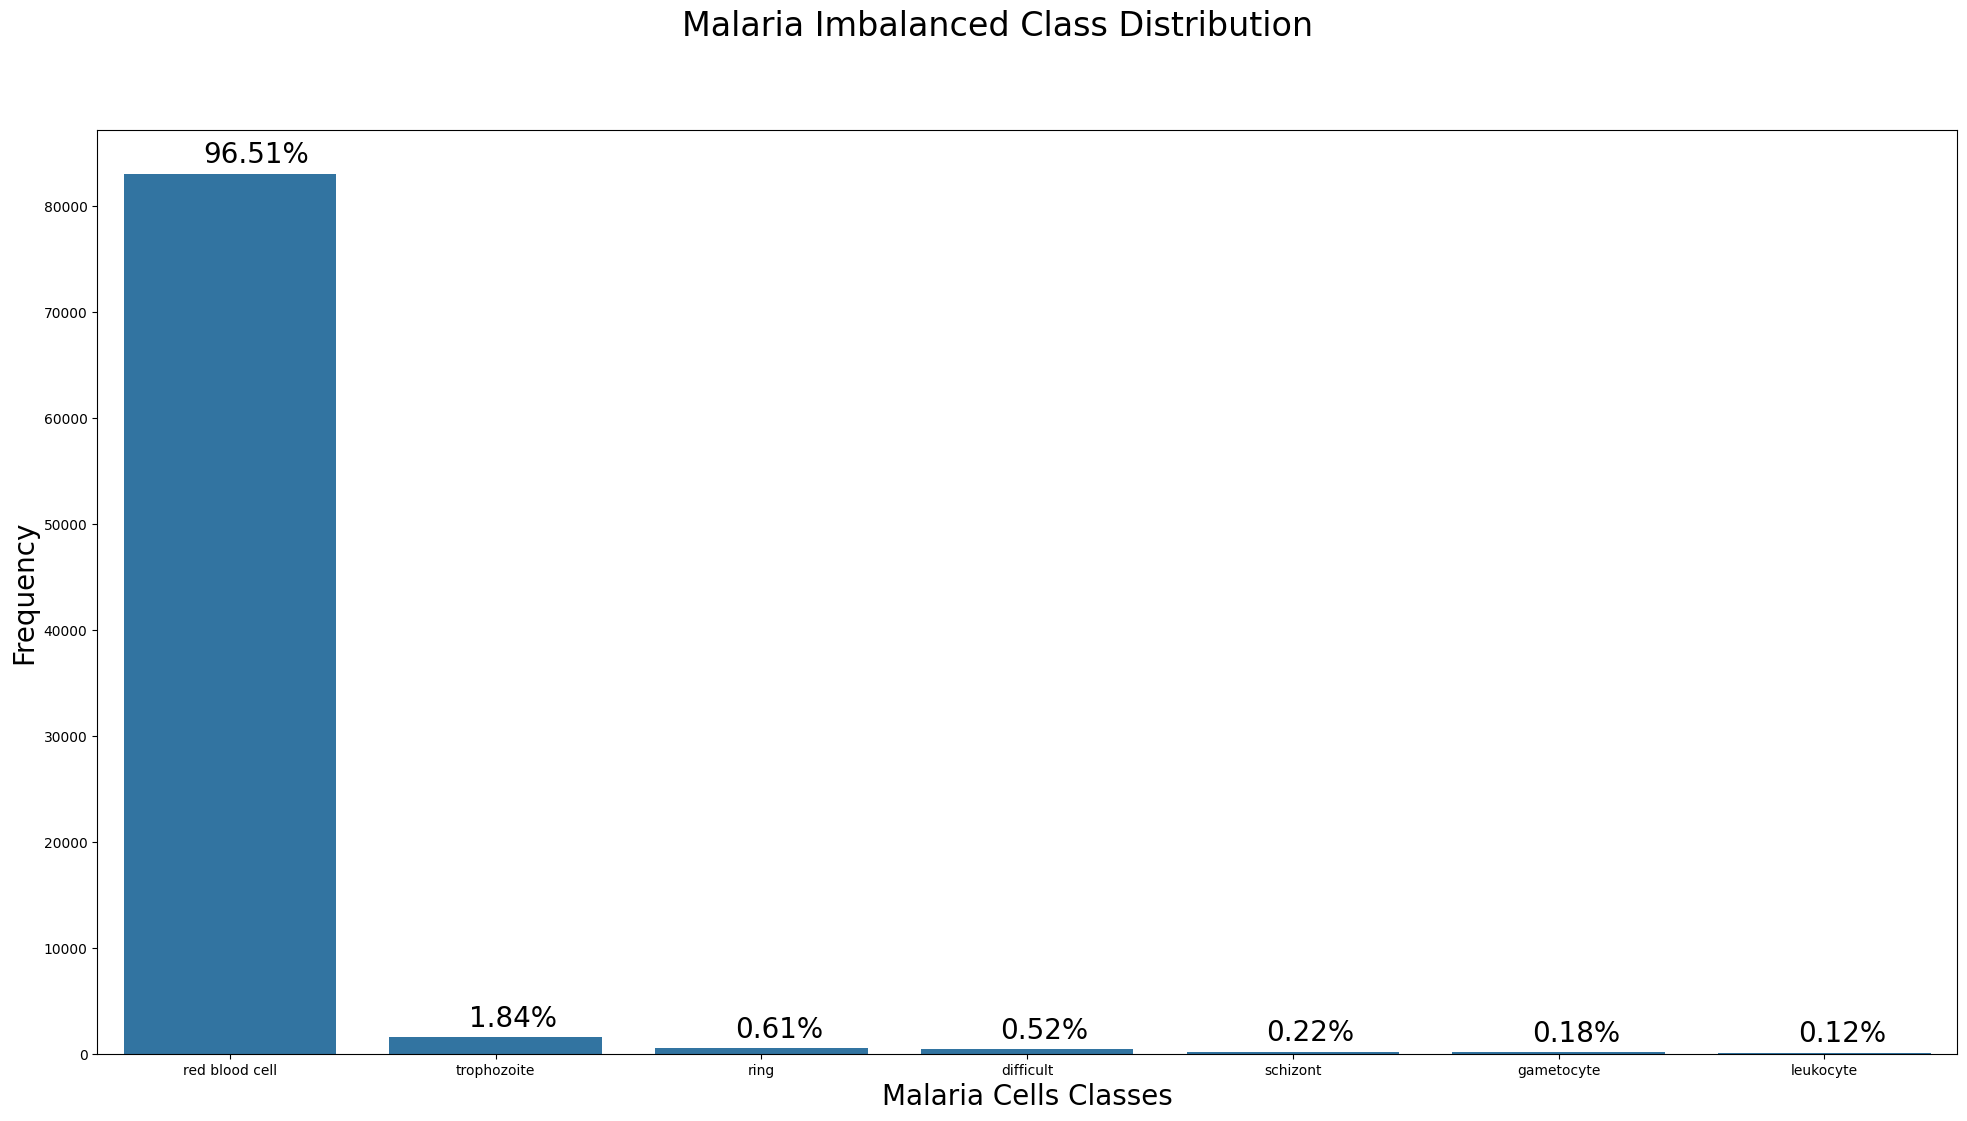

In [12]:
# this is a class distribution 
fig,ax = plt.subplots(figsize=(24,12))
temp = data['category'].value_counts().values
sns.barplot(x = data['category'].value_counts().index.tolist(),y = data['category'].value_counts().values.tolist())
for i,text in enumerate(data['category'].value_counts(normalize = True).items()):
    ax.annotate("{:.2f}%".format(text[1]*100),xy = (i-0.10,temp[i]+1000),fontsize = 20)
plt.xlabel("Malaria Cells Classes",fontsize = 20)
plt.ylabel("Frequency",fontsize = 20)
plt.suptitle("Malaria Imbalanced Class Distribution",fontsize = 24)
plt.show()

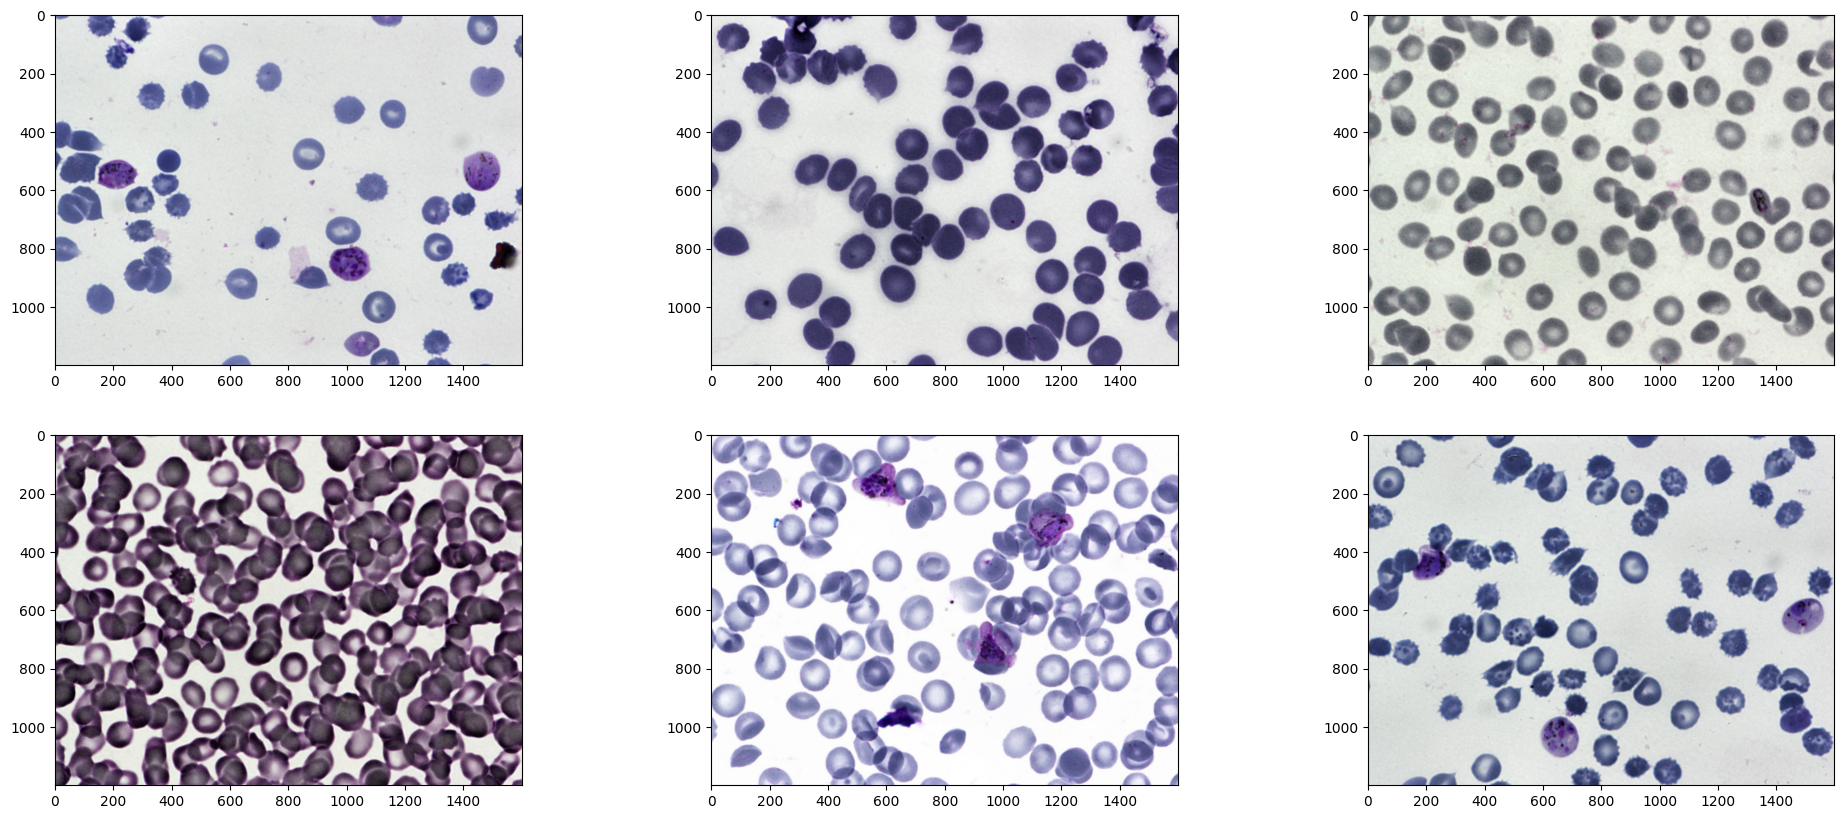

In [13]:
plt.figure(figsize = (24,10))
count=1
for row in list(np.random.choice(train.shape[0],6)): # taking 6 random index inputs and displaying the image
    path = os.path.normpath(
        os.path.join(
            r"C:\\Users\\BMEI CMU\\Documents\\GitHub\\WORK\\Windows\\CODE_BME\\PROJECT_MALARIA\\malaria",
            train.iloc[row]['image']['pathname'].lstrip("/")
        )
    )
    im = Image.open(path)
    plt.subplot(2,3,count)
    plt.imshow(im)
    plt.grid(False)
    count+=1

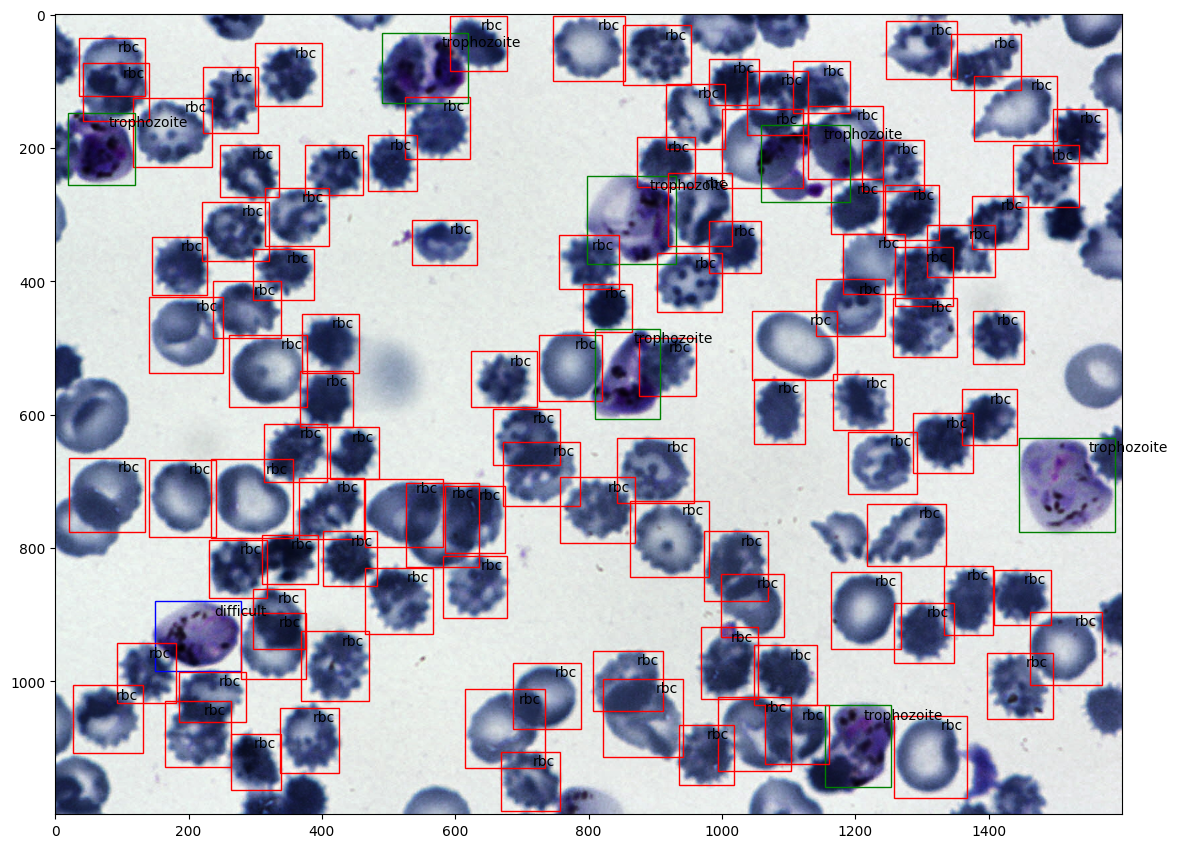

In [16]:
fig = plt.figure(figsize = (24,8))

ax = fig.add_axes([0,0,1,1])
row = np.random.choice(train.shape[0],1)[0]
path = os.path.normpath(
    os.path.join(
        r"C:\\Users\\BMEI CMU\\Documents\\GitHub\\WORK\\Windows\\CODE_BME\\PROJECT_MALARIA\\malaria",
        train.iloc[row]['image']['pathname'].lstrip("/")
    )
)
image = plt.imread(path)
plt.imshow(image)

for _,row in data[data.img_path==path].iterrows():
    xmin = row.min_c # x1
    xmax = row.max_c # x2
    ymin = row.min_r # y1
    ymax = row.max_r # y2

    l = xmax-xmin # x2-x1
    b = ymax-ymin # y2-y1

    if row.category=='red blood cell':
        color='r' # bounding box color for RBC
        ax.annotate('rbc',xy=(xmax-40,ymin+20)) # bonding box dimension
    elif row.category=='trophozoite':
        color='g' # bounding box color for trophozoite
        ax.annotate('trophozoite',xy=(xmax-40,ymin+20)) # bonding box dimension
    elif row.category=='difficult':
        color='b'# bounding box color for difficult
        ax.annotate('difficult',xy=(xmax-40,ymin+20)) # bonding box dimension
    elif row.category=='ring':
        color='r' # bounding box color for ring
        ax.annotate('ring',xy=(xmax-40,ymin+20)) # bonding box dimension
    elif row.category=='schizont':
        color='r' # bounding box color for schizont
        ax.annotate('schizont',xy=(xmax-40,ymin+20)) # bonding box dimension
    elif row.category=='gametocyte':
        color='o' # bounding box color for gametocyte
        ax.annotate('gametocyte',xy=(xmax-40,ymin+20)) # bonding box dimension
    elif row.category=='leukocyte':
        color='b' # bounding box color for Leukocyte
        ax.annotate('leukocyte',xy=(xmax-40,ymin+20)) # bonding box dimension

    rect = patches.Rectangle((xmin,ymin), l, b, edgecolor = color, facecolor = 'none')
    ax.add_patch(rect)


# rbc and leukocyte are uninfected cells
# and other four classes trophozoite,difficult,ring,schizont are infected cells.
